<a href="https://colab.research.google.com/github/NVN404/ai-assignment/blob/main/Q2code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload your checkerboard image:


Saving 99.webp to 99 (10).webp
Attempting to find 5x5 checkerboard...
Attempting to find 5x6 checkerboard...
Successfully found 5x6 checkerboard!

Detected checkerboard size: 5x6 (internal corners)
Found 30 corners. Refining and running RANSAC...
RANSAC finished: Found 30 inlier points out of 30.


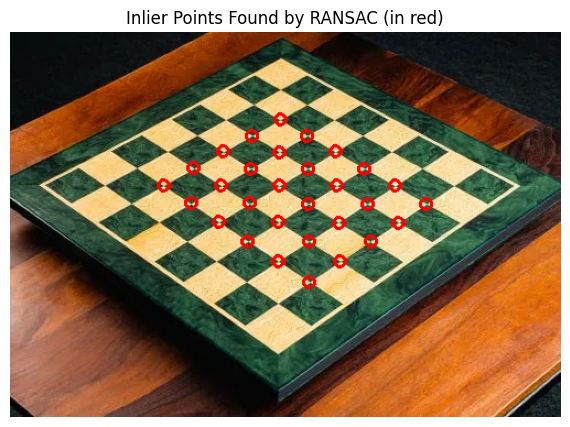

Starting robust optimization with scipy.least_squares...
`xtol` termination condition is satisfied.
Function evaluations 124, initial cost 3.2013e+03, final cost 1.3230e+03, first-order optimality 2.31e+01.
Optimization finished in 0.25 seconds.
Optimization Successful.

--- Optimization Results ---
Estimated Focal Lengths (fx, fy): 493.42, 345.91
Estimated Principal Point (cx, cy): 242.43, 142.40
Estimated Radial Distortion (k1, k2): -21.178676, 13.571640


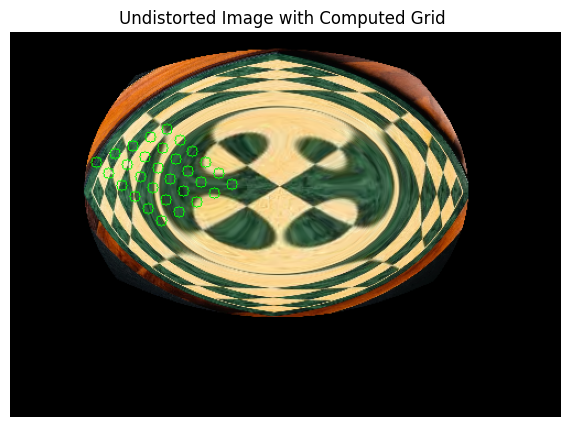

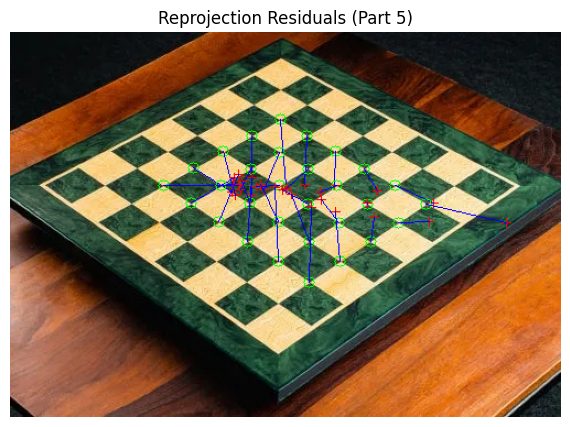

Final RMS Reprojection Error: 7.7356 pixels


In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io
from scipy.optimize import least_squares
import time
import ipywidgets as widgets
from IPython.display import display

squareSizeMm = 20.0
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

print("Upload your checkerboard image:")
uploadedFiles = files.upload()

if uploadedFiles:
    fileName = next(iter(uploadedFiles))
    imageData = uploadedFiles[fileName]

    # Read image
    imageStream = io.BytesIO(imageData)
    imagePIL = Image.open(imageStream).convert('RGB')
    imageBgr = cv2.cvtColor(np.array(imagePIL), cv2.COLOR_RGB2BGR)
    grayImage = cv2.cvtColor(imageBgr, cv2.COLOR_BGR2GRAY)
    height, width = grayImage.shape[:2]
    found_size = None
    found_corners = None

    # Iterate through a range of possible checkerboard sizes
    for rows in range(5, 11):
        for cols in range(5, 11):
            checkerboardSize_attempt = (rows, cols)
            print(f"Attempting to find {rows}x{cols} checkerboard...")
            foundCorners, corners = cv2.findChessboardCorners(grayImage, checkerboardSize_attempt, None)

            if foundCorners:
                print(f"Successfully found {rows}x{cols} checkerboard!")
                found_size = checkerboardSize_attempt
                found_corners = corners
                break
        if found_size:
            break

    if found_size:
        checkerboardSize = found_size
        corners = found_corners # Use the corners found during detection
        print(f"\nDetected checkerboard size: {checkerboardSize[0]}x{checkerboardSize[1]} (internal corners)")
        objectPointsTemplate = np.zeros((checkerboardSize[0] * checkerboardSize[1], 3), np.float32)
        objectPointsTemplate[:, :2] = np.mgrid[0:checkerboardSize[0], 0:checkerboardSize[1]].T.reshape(-1, 2) * squareSizeMm
        print(f"Found {len(corners)} corners. Refining and running RANSAC...")
        refinedCorners = cv2.cornerSubPix(grayImage, corners, (11, 11), (-1, -1), criteria)
        imagePoints_all = refinedCorners.reshape(-1, 2)
        objectPoints_2D = objectPointsTemplate[:, :2]
        H, mask = cv2.findHomography(objectPoints_2D, imagePoints_all, cv2.RANSAC, 5.0)
        inlier_mask = mask.ravel().astype(bool)
        inlier_object_points_3d = objectPointsTemplate[inlier_mask]
        inlier_image_points_2d = imagePoints_all[inlier_mask]
        print(f"RANSAC finished: Found {len(inlier_image_points_2d)} inlier points out of {len(imagePoints_all)}.")
        plt.figure(figsize=(10, 5))
        drawnImage = imageBgr.copy()
        for pt in inlier_image_points_2d:
             cv2.circle(drawnImage, (int(pt[0]), int(pt[1])), 5, (0,0,255), 2) # Draw inliers in red
        plt.imshow(cv2.cvtColor(drawnImage, cv2.COLOR_BGR2RGB))
        plt.title('Inlier Points Found by RANSAC (in red)')
        plt.axis('off')
        plt.show()

        def project_points_cost_function(params, object_points, image_points):
            fx, fy, cx, cy, k1, k2 = params[:6]
            rvec = params[6:9]
            tvec = params[9:12]
            cameraMatrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
            distCoeffs = np.array([k1, k2, 0, 0, 0])

            # It projects 3D points to 2D using the current parameters
            projected_points, _ = cv2.projectPoints(object_points, rvec, tvec, cameraMatrix, distCoeffs)
            residuals = (projected_points.reshape(-1, 2) - image_points).ravel()

            return residuals

    # optimisation
        fx_guess = width
        fy_guess = height
        cx_guess = width / 2
        cy_guess = height / 2
        k1_guess = 0.0
        k2_guess = 0.0
        rvec_guess = np.zeros(3)
        tvec_guess = np.array([0.0, 0.0, 500.0]) # here we are Assuming ~50cm away

        initial_params = np.array([
            fx_guess, fy_guess, cx_guess, cy_guess,
            k1_guess, k2_guess,
            *rvec_guess,
            *tvec_guess
        ])

        print("Starting robust optimization with scipy.least_squares...")
        start_time = time.time()
        result = least_squares(
            project_points_cost_function,
            initial_params,
            args=(inlier_object_points_3d, inlier_image_points_2d),
            method='trf',
            loss='huber',
            verbose=1
        )

        end_time = time.time()
        print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

        if not result.success:
            print("Optimization FAILED.")
        else:
            print("Optimization Successful.")
            final_params = result.x
            fx, fy, cx, cy, k1, k2 = final_params[:6]
            rvec_opt = final_params[6:9]
            tvec_opt = final_params[9:12]

            # Build the final matrices
            cameraMatrix_opt = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
            distCoeffs_opt = np.array([k1, k2, 0, 0, 0])
            print("\n--- Optimization Results ---")
            print(f"Estimated Focal Lengths (fx, fy): {fx:.2f}, {fy:.2f}")
            print(f"Estimated Principal Point (cx, cy): {cx:.2f}, {cy:.2f}")
            print(f"Estimated Radial Distortion (k1, k2): {k1:.6f}, {k2:.6f}")

            newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix_opt, distCoeffs_opt, (width, height), 1, (width, height))
            undistortedImage = cv2.undistort(imageBgr, cameraMatrix_opt, distCoeffs_opt, None, newCameraMatrix)
            undistorted_grid_points, _ = cv2.projectPoints(objectPointsTemplate, rvec_opt, tvec_opt, newCameraMatrix, np.zeros(5))

            # Draw the grid on the undistorted image
            undistortedImageWithGrid = undistortedImage.copy()
            for pt in undistorted_grid_points:
                cv2.circle(undistortedImageWithGrid, (int(pt[0][0]), int(pt[0][1])), 5, (0, 255, 0), 1)

            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(undistortedImageWithGrid, cv2.COLOR_BGR2RGB))
            plt.title('Undistorted Image with Computed Grid ')
            plt.axis('off')
            plt.show()


            reprojectedPoints, _ = cv2.projectPoints(inlier_object_points_3d, rvec_opt, tvec_opt, cameraMatrix_opt, distCoeffs_opt)
            reprojectedPoints = reprojectedPoints.reshape(-1, 2)

            # Calculating RMS error
            error = cv2.norm(inlier_image_points_2d, reprojectedPoints, cv2.NORM_L2) / len(reprojectedPoints)


            residualImage = imageBgr.copy()
            for detected, predicted in zip(inlier_image_points_2d, reprojectedPoints):
                # Green circle is Detected inlier
                cv2.circle(residualImage, (int(detected[0]), int(detected[1])), 5, (0, 255, 0), 1)
                # Red cross is Predicted  position
                cv2.drawMarker(residualImage, (int(predicted[0]), int(predicted[1])), (0, 0, 255), cv2.MARKER_CROSS, 8, 1)
                # Blue line is The error
                cv2.line(residualImage, (int(detected[0]), int(detected[1])), (int(predicted[0]), int(predicted[1])), (255, 0, 0), 1)

            plt.figure(figsize=(10, 5))
            plt.imshow(cv2.cvtColor(residualImage, cv2.COLOR_BGR2RGB))
            plt.title('Reprojection Residuals (Part 5)')
            plt.axis('off')
            plt.show()

            print(f"Final RMS Reprojection Error: {error:.4f} pixels")

    else:
        print("\nCould not automatically detect checkerboard size within the specified range.")
else:
    print("Image Upload Failed. Please try again.")